In [2]:
# auto reload

%load_ext autoreload
%autoreload 2

In [3]:
from dsd import DATA_DIR
from dsd.diffusion_rendering import * 




/home/tlips/.conda/envs/dsd/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/tlips/.conda/envs/dsd/lib/python3.10/site-packages/controlnet_aux/mediapipe_face/mediapipe_face_common.py:7: UserWarning: The module 'mediapipe' is not installed. The package will have limited functionality. Please install it using the command: pip install 'mediapipe'
  warnings.warn(
/home/tlips/.conda/envs/dsd/lib/python3.10/site-packages/controlnet_aux/segment_anything/modeling/tiny_vit_sam.py:654: UserWarning: Overwriting tiny_vit_5m_224 in registry with controlnet_aux.segment_anything.modeling.tiny_vit_sam.tiny_vit_5m_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  return register_model(fn_wrapper)
/home/tlips/.conda/envs/dsd/lib/python3.10/site-p

In [5]:
image_dir = DATA_DIR / "renders/mugs/small/Threshold_porcelain_Coffee_Mug_All_over_bead/000"
input_images = DiffusionRenderInputImages.from_render_dir(image_dir)
#input_images.depth_image[input_images.depth_image > 1.0] = 1.0


In [6]:
print(input_images.depth_image.shape)
print(input_images.depth_image[0,200])
print(input_images.depth_image.dtype)
print(input_images.get_rgb_image_torch().shape)
print(input_images.rgb_image[100,100])



(512, 512)
3.0
float32
torch.Size([1, 3, 512, 512])
[0.27450982 0.27450982 0.27450982]


In [7]:
canny_edges = get_canny_edges_from_image(input_images.rgb_image,20,100)
inverted_depth = input_images.get_inverted_depth_image()
normals = input_images.get_normal_map()
depth_canny_edges = get_canny_edges_from_image(inverted_depth,20,100)

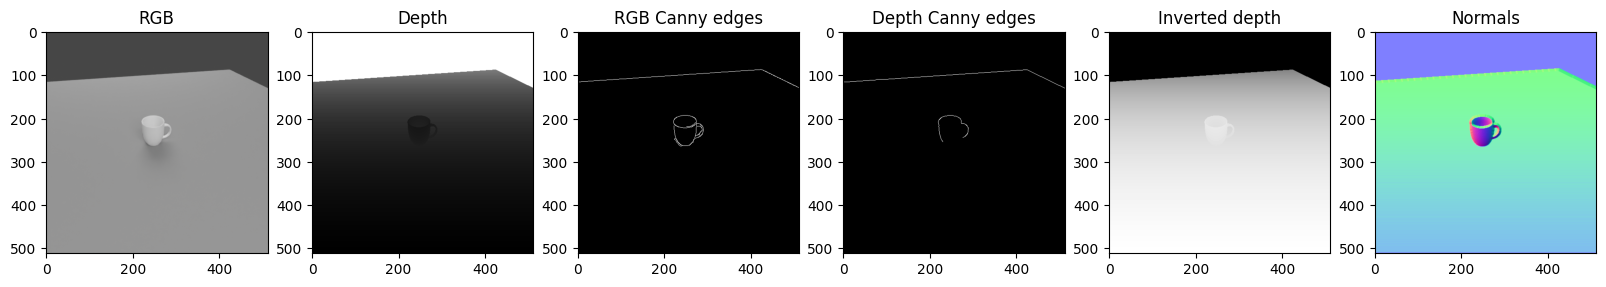

In [8]:
# plot original image and depth, as well as the processed images 
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 6, figsize=(20, 5))
axes[0].imshow(input_images.rgb_image)
axes[0].set_title("RGB")
axes[1].imshow(input_images.depth_image, cmap="gray")
axes[1].set_title("Depth")
axes[2].imshow(canny_edges, cmap="gray")
axes[2].set_title("RGB Canny edges")
axes[3].imshow(depth_canny_edges, cmap="gray")
axes[3].set_title("Depth Canny edges")
axes[4].imshow(inverted_depth, cmap="gray")
axes[4].set_title("Inverted depth")
axes[5].imshow(normals)
axes[5].set_title("Normals")


plt.show()


In [10]:
import matplotlib.pyplot as plt
def visualize_results(rgb,control, images):
    # plot original image and depth, as well as the processed images
    fig, axes = plt.subplots(1, 6, figsize=(20, 5))
    axes[0].imshow(rgb)
    axes[0].set_title("RGB")
    axes[1].imshow(control)
    axes[1].set_title("Control Image")
    axes[2].imshow(images[0])
    axes[2].set_title("prompted")
    axes[3].imshow(images[1])
    axes[3].set_title("prompted")
    axes[4].imshow(images[2])
    axes[4].set_title("prompted")
    axes[5].imshow(images[3])
    axes[5].set_title("prompted")
    plt.show()


In [10]:
strength = 1.0
controlnet_guidance_scale = 1.0
n_steps = 50

100%|██████████| 50/50 [00:10<00:00,  4.72it/s]


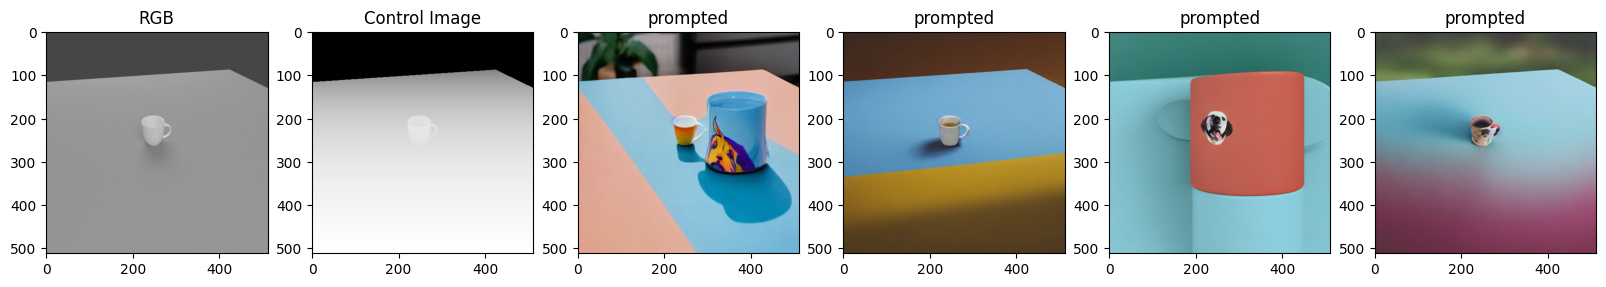

: 

In [14]:
renderer = ControlNetFromDepthRenderer(num_inference_steps=50,controlnet_guidance_scale=1.0, strength=1.0)
images = renderer(["a colorful mug with a picture of a dog on a blue surface"], input_images)
visualize_results(input_images.rgb_image, renderer.get_control_image(input_images)[0].numpy().transpose(1,2,0),images)

100%|██████████| 50/50 [00:10<00:00,  4.71it/s]


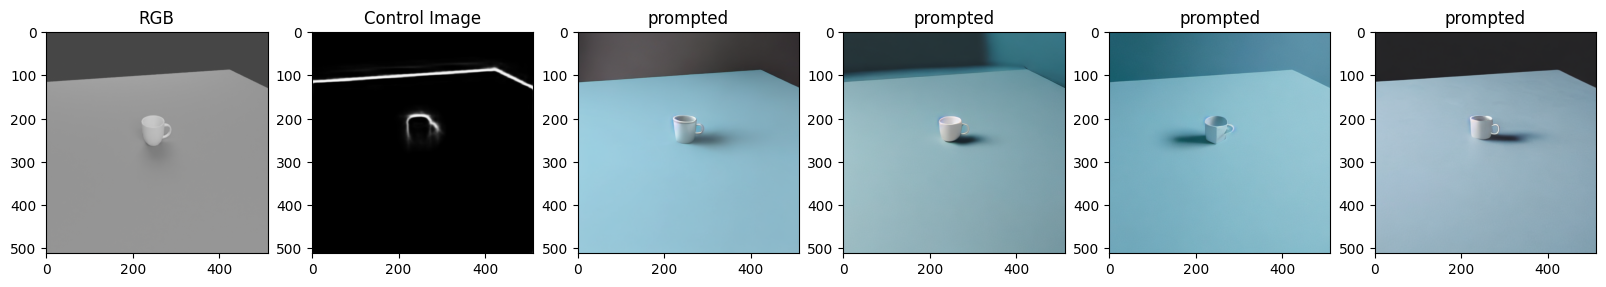

In [11]:
renderer = ControlnetfromHEDRenderer(num_inference_steps=50,controlnet_guidance_scale=1.0)
images = renderer(["a colorful mug on a blue surface"], input_images)
visualize_results(input_images.rgb_image, renderer.get_control_image(input_images),images)

100%|██████████| 50/50 [00:10<00:00,  4.73it/s]


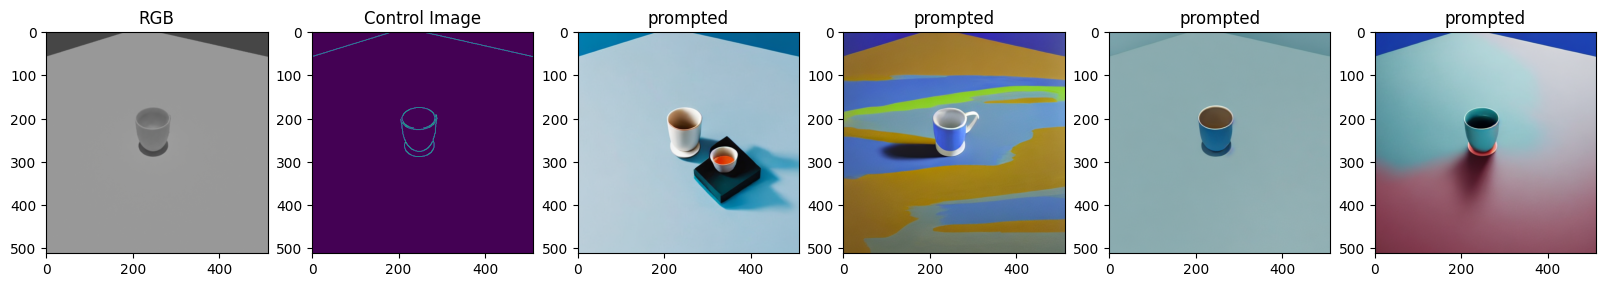

In [14]:
renderer = ControlNetFromCannyRenderer(num_inference_steps=n_steps,controlnet_guidance_scale=controlnet_guidance_scale, strength = strength)
images = renderer(["a colorful mug on a blue surface"], input_images)
visualize_results(input_images.rgb_image, renderer.get_control_image(input_images),images)

Loading pipeline components...: 100%|██████████| 7/7 [00:15<00:00,  2.27s/it]
/home/tlips/.conda/envs/dsd/lib/python3.10/site-packages/diffusers/pipelines/controlnet/pipeline_controlnet_img2img.py:806: FutureWarning: You have passed 4 text prompts (`prompt`), but only 1 initial images (`image`). Initial images are now duplicating to match the number of text prompts. Note that this behavior is deprecated and will be removed in a version 1.0.0. Please make sure to update your script to pass as many initial images as text prompts to suppress this warning.
  deprecate("len(prompt) != len(image)", "1.0.0", deprecation_message, standard_warn=False)
100%|██████████| 50/50 [00:10<00:00,  4.74it/s]


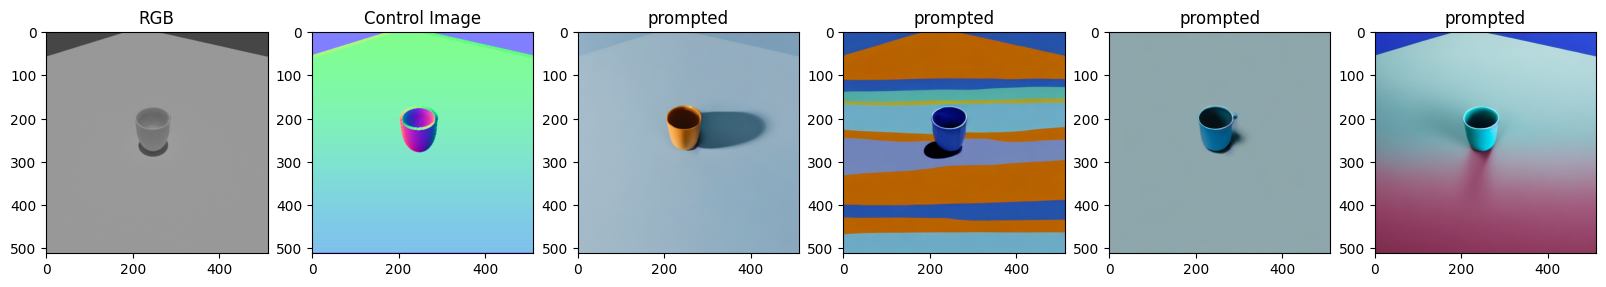

In [16]:
renderer = ControlNetFromNormalsRenderer()
images = renderer(["a colorful mug on a blue surface"], input_images)
visualize_results(input_images.rgb_image, renderer.get_control_image(input_images)[0].numpy().transpose(1,2,0),images)